In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import glob
import itertools
import os

from run import Run
from runs_db import db as runs_db

[('martak', 108), ('gcp', 62), ('deepnet2', 83), ('fiit-gcp-1', 10), ('fiit-gcp-2', 13), ('fiit-gcp-3', 14), ('acer', 33)]


In [2]:
log_path = '/home/mpikuliak/logs'
runs = []

for server in runs_db:
    paths = glob.glob(os.path.join(log_path, server, '*'))
    paths = iter(sorted(paths))

    try:
        for (number, type_, code) in runs_db[server]:
            for _ in range(number):
                try:
                    path = next(paths)
                    runs.append(Run(path, type_, code))
                except KeyError:
                    print(path)
    except StopIteration:
        pass


In [3]:
tasks = ['dep', 'lmo', 'ner', 'pos']
langs = ['cs', 'de', 'en', 'es']

task_metr = {
    'dep': 'las',
    'lmo': 'perplexity',
    'ner': 'chunk_f1',
    'pos': 'acc'
}

task_max = {
    'dep': True,
    'lmo': False,
    'ner': True,
    'pos': True
}

def draw_graphs(metric_func, tasks, langs, role, run_codes=None, run_types=None):
    fig, axes = plt.subplots(len(tasks), len(langs), figsize=(5*len(langs), 4*len(tasks)), squeeze=False)

    relevant_runs = ['vanilla']

    for task, lang in itertools.product(tasks, langs):
        for run in runs:
            if (
                run.contains(task, lang) and
                (run_codes is None or run.code in run_codes) and
                (run_types is None or run.type in run_types)
            ):

                history = run.history(
                    metric=metric_func(task),
                    task=task,
                    language=lang,
                    role=role)
                axes[tasks.index(task), langs.index(lang)].plot(list(history), label=f'{run.code}-{run.type}')

    for ax, col in zip(axes[0], langs):
        ax.set_title(col)

    for ax, row in zip(axes[:, 0], tasks):
        ax.set_ylabel(row, rotation=0, size='large')
        
    for ax_row in axes:
        for ax in ax_row:
            ax.legend()

    plt.show()
    
def print_results(metric_func, metric_max_func, tasks, langs, run_codes=None, run_types=None, print_lambda=None):
    
    if print_lambda is None:
        print_lambda = lambda val, run: print(f'{val:.2f}')
        
    output = []
    
    for task, lang in itertools.product(tasks, langs):
        for run in runs:
            if (
                run.contains(task, lang) and
                (run_codes is None or run.code in run_codes) and
                (run_types is None or run.type in run_types)
            ):
                result = run.metric_eval(
                    metric=metric_func(task),
                    max_=metric_max_func(task),
                    task=task,
                    language=lang)
                res = result[0]
                if res < 1.01:
                    res *= 100
                print_lambda(res, run)
                output.append((res, run))
                
    return output

In [ ]:
print_results(lambda task: task_metr[task], lambda task: task_max[task], ['dep'], ['cs'],
     ['private-focused-0.75'], ['ml'], lambda val, run: print(f'{val:.2f} {run.path}'))

print_results(lambda task: task_metr[task], lambda task: task_max[task], ['dep'], ['es'],
     ['private-focused'], ['ml'], lambda val, run: print(f'{val:.2f} {run.path}'))

print_results(lambda task: task_metr[task], lambda task: task_max[task], ['ner'], ['cs'],
     ['vanilla'], ['mt'], lambda val, run: print(f'{val:.2f} {run.path}'))

print('87.69 /home/fiit/logs/acer/2019-02-22-025619')

print_results(lambda task: task_metr[task], lambda task: task_max[task], ['pos'], ['cs'],
     ['no-adv-tsh-focused-0.75'], ['mt'], lambda val, run: print(f'{val:.2f} {run.path}'))

print_results(lambda task: task_metr[task], lambda task: task_max[task], ['pos'], ['es'],
     ['no-adv-tsh-focused'], ['mt'], lambda val, run: print(f'{val:.2f} {run.path}'))

print()

print_results(lambda task: task_metr[task], lambda task: task_max[task], ['dep'], ['de'],
     ['private'], ['mt'], lambda val, run: print(f'{val:.2f} {run.path}'))

print_results(lambda task: task_metr[task], lambda task: task_max[task], ['dep'], ['en'],
     ['private'], ['ml'], lambda val, run: print(f'{val:.2f} {run.path}'))

print('83.07 /home/fiit/logs/deepnet2/2019-02-26-041529')
print('85.07 /home/fiit/logs/acer/2019-02-20-213852')

print_results(lambda task: task_metr[task], lambda task: task_max[task], ['pos'], ['de'],
     ['vanilla'], ['mt'], print_lambda=lambda val, run: print(f'{val:.2f} {run.path}'))

print_results(lambda task: task_metr[task], lambda task: task_max[task], ['pos'], ['en'],
     ['private'], ['mt'], print_lambda=lambda val, run: print(f'{val:.2f} {run.path}'))

In [ ]:
# draw_graphs(lambda task: task_metr[task], tasks, langs, 'test',
#              ['private-focused-200', 'no-adv-tsh-200'], ['ml'])
draw_graphs(lambda _: 'unit_strength_2', tasks, langs, 'test',
             ['private', 'no-adv-task-sharing'], ['ml', 'mt'])

In [ ]:
pairs = [('dep','cs'), ('dep','es'), ('ner','cs'), ('ner','es'), ('pos','cs'), ('pos','es'),]

def print_row(code, type_):
    for t, l in pairs:
        print_results(lambda task: task_metr[task], lambda task: task_max[task], [t], [l],
                    [code], [type_], lambda val, run: print(f'{val:.2f}', end=' '))

codes = ['private-focused', 'no-adv-tsh-focused']
types = ['ml', 'mt']

print('baseline 89.16 86.51 78.10 86.77 98.89 96.46')
print('best unfocused 89.16 86.70 81.58 87.69 99.04 96.87')


for code in codes:
    for type_ in types:
        print(f'{code}{type_}', end='\t')
        print_row(code, type_)
        print()
        
codes = ['private-focused-0.75', 'no-adv-tsh-focused-0.75']
types = ['ml', 'mt']

for code in codes:
    for type_ in types:
        print(f'{code}{type_}', end='\t\t')
        print_row(code, type_)
        print()
        
codes = ['private-focused-0.75', 'no-adv-tsh-focused-0.75', 'private-focused', 'no-adv-tsh-focused']
types = ['mtml']

for code in codes:
    for type_ in types:
        print(f'{code}{type_}', end='\t\t')
        print_row(code, type_)
        print()


# print_results(lambda task: task_metr[task], lambda task: task_max[task], ['dep'], ['en'],
#             ['dep-adv-lambda-0.25'])
# print_results(lambda task: task_metr[task], lambda task: task_max[task], ['dep'], ['en'],
#             ['dep-adv-lambda-0.125'])
# print_results(lambda task: task_metr[task], lambda task: task_max[task], ['dep'], ['en'],
#             ['no-adv-task-sharing'], ['ml'])

In [ ]:
import numpy as np

pairs = list(itertools.product(['dep', 'ner', 'pos'], langs))

def print_row(code, type_, msg):
    print(msg, end=' ')
    for t, l in pairs:
        print_results(lambda task: task_metr[task], lambda task: task_max[task], [t], [l],
                    [code], [type_], lambda val, run: print(f'{val:.2f}', end=' '))
    print()
        
print_row('vanilla', 'stsl', 'Baseline')

print('Best1', end=' ')
for t, l in pairs:
    output = print_results(lambda task: task_metr[task], lambda task: task_max[task], [t], [l],
                ['one-aux'], print_lambda=lambda _, __: ...)
    print(f'{max([r[0] for r in output]):.2f}', end=' ')
print()

print('Avg', end=' ')
for t, l in pairs:
    output = print_results(lambda task: task_metr[task], lambda task: task_max[task], [t], [l],
                ['one-aux'], print_lambda=lambda _, __: ...)
    print(f'{np.mean([r[0] for r in output]):.2f}', end=' ')
print()


print('Worst1', end=' ')
for t, l in pairs:
    output = print_results(lambda task: task_metr[task], lambda task: task_max[task], [t], [l],
                ['one-aux'], print_lambda=lambda _, __: ...)
    print(f'{min([r[0] for r in output]):.2f}', end=' ')
print()

print_row('vanilla', 'mt', 'A-MT')
print_row('no-adv-task-sharing', 'ml', 'A-ML')
print_row('no-adv-task-sharing', 'mtml', 'A-MTML')
print_row('private', 'mt', 'B-MT')
print_row('private', 'ml', 'B-ML')
print_row('private', 'mtml', 'B-MTML')
print_row('no-adv', 'ml', 'C-ML')
print_row('no-adv', 'mtml', 'C-MTML')

In [ ]:
for t, l in pairs:
    output = print_results(lambda task: task_metr[task], lambda task: task_max[task], [t], [l],
                ['one-aux'], print_lambda=lambda _, __: ...)
    output = sorted(output, key=lambda r: -r[0])
    print(output[0][1].hparams['tasks'])
    #print(f'{max([r[0] for r in output]):.2f}', end=' ')
print()

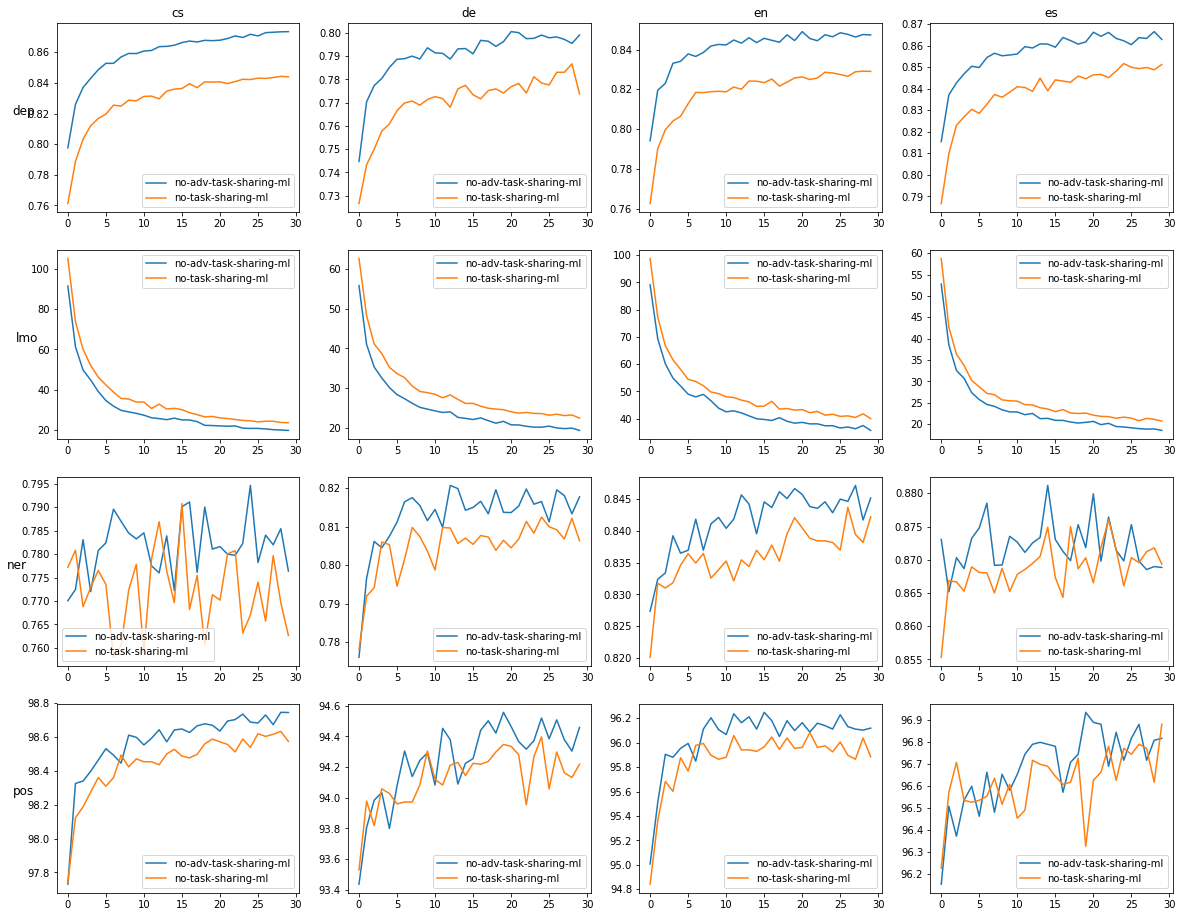

0.06561437837575122
0.09279892445176093


In [20]:
draw_graphs(lambda task: task_metr[task], tasks, langs, 'test', ['no-task-sharing', 'no-adv-task-sharing'], ['ml'])


o = []
for task, lang in itertools.product(['dep', 'ner', 'pos'], langs):
        o.append(print_results(lambda task: task_metr[task], lambda task: task_max[task], [task], [lang],
         ['no-task-sharing'], ['ml'], print_lambda=lambda val, run: ...))
o = [val[0][0] for val in o]
p = []
for task, lang in itertools.product(['dep', 'ner', 'pos'], langs):
        p.append(print_results(lambda task: task_metr[task], lambda task: task_max[task], [task], [lang],
         ['no-adv-task-sharing'], ['ml'], print_lambda=lambda val, run: ...))
p = [val[0][0] for val in p]
print(np.mean([(p[i]-o[i])/(100-o[i]) for i in range(len(o))]))

o = []
for task, lang in itertools.product(['dep', 'ner', 'pos'], langs):
        o.append(print_results(lambda task: task_metr[task], lambda task: task_max[task], [task], [lang],
         ['private-with-adv'], ['ml'], print_lambda=lambda val, run: ...))
o = [val[0][0] for val in o]
p = []
for task, lang in itertools.product(['dep', 'ner', 'pos'], langs):
        p.append(print_results(lambda task: task_metr[task], lambda task: task_max[task], [task], [lang],
         ['private'], ['ml'], print_lambda=lambda val, run: ...))
p = [val[0][0] for val in p]
print(np.mean([(p[i]-o[i])/(100-o[i]) for i in range(len(o))]))


In [6]:
print_results(lambda task: task_metr[task], lambda task: task_max[task], tasks, langs,
     ['fine-tune'], print_lambda=lambda val, run: print(f'{val:.2f} {run.hparams["train_only"]} {run.path}'))

89.69 dep-cs /home/mpikuliak/logs/deepnet2/2019-03-01-183851
80.24 dep-de /home/mpikuliak/logs/gcp/2019-03-01-215321
85.25 dep-en /home/mpikuliak/logs/martak/2019-03-02-153216
86.77 dep-es /home/mpikuliak/logs/deepnet2/2019-03-01-201809
79.11 ner-cs /home/mpikuliak/logs/martak/2019-03-02-124127
82.64 ner-de /home/mpikuliak/logs/deepnet2/2019-03-02-004011
84.67 ner-en /home/mpikuliak/logs/acer/2019-03-02-154517
86.87 ner-es /home/mpikuliak/logs/acer/2019-03-02-104212
99.08 pos-cs /home/mpikuliak/logs/deepnet2/2019-03-01-215803
94.83 pos-de /home/mpikuliak/logs/martak/2019-03-02-182030
96.05 pos-en /home/mpikuliak/logs/gcp/2019-03-02-022205
96.73 pos-es /home/mpikuliak/logs/deepnet2/2019-03-01-231826


[(89.6894316384639, <run.Run at 0x7f45942ece48>),
 (80.24357239512855, <run.Run at 0x7f459639a400>),
 (85.25472423420871, <run.Run at 0x7f4598a092b0>),
 (86.772821858319, <run.Run at 0x7f45955cf4a8>),
 (79.11145752143415, <run.Run at 0x7f45976b7cf8>),
 (82.63649778652238, <run.Run at 0x7f459430da90>),
 (84.67050265986322, <run.Run at 0x7f459347da58>),
 (86.8671828469327, <run.Run at 0x7f45934c6a90>),
 (99.07599974510337, <run.Run at 0x7f4594300c88>),
 (94.83331283060647, <run.Run at 0x7f45974c0b38>),
 (96.05066159511189, <run.Run at 0x7f4598329978>),
 (96.73391839319642, <run.Run at 0x7f459435e2e8>)]

mt 0 0.2934526573624224
mt 1 0.13179855461553533
mt 2 -0.0327839208816253
ml 0 0.21771373269461478
ml 1 0.0903307204737419
ml 2 -0.04338914166882945
mtml 0 0.3252228993250306
mtml 1 0.13384119185615473
mtml 2 -0.12324173550432853


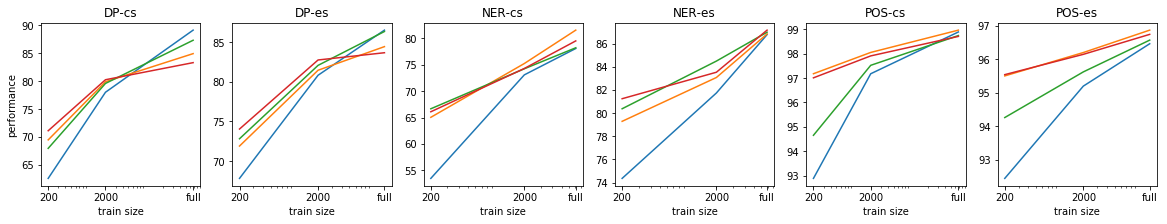

In [9]:
def yield_results(task, lang):
    
    code_types = [
        ('vanilla-200', 'stsl'),
        ('vanilla-2000', 'stsl'),
        ('vanilla', 'stsl'),
        ('no-adv-tsh-200', 'mt'),
        ('no-adv-tsh-2000', 'mt'),
        ('vanilla', 'mt'),
        ('no-adv-tsh-200', 'ml'),
        ('no-adv-tsh-2000', 'ml'),
        ('no-adv-task-sharing', 'ml'),
        ('no-adv-tsh-200', 'mtml'),
        ('no-adv-tsh-2000', 'mtml'),
        ('no-adv-task-sharing', 'mtml'),

        
    ]
    
    for code, type_ in code_types:

        output = print_results(lambda task: task_metr[task], lambda task: task_max[task], [task], [lang],
         [code], [type_], print_lambda=lambda val, run: ...)
        for res, run in output:
            if run.hparams['limited_task_language'] in [f'{task}-{lang}', None]:
                yield res

fig, axes = plt.subplots(1, 6, figsize=(20, 3), squeeze=False)

sizes = {
    ('dep', 'cs'): 67900,
    ('dep', 'es'): 14000,
    ('ner', 'cs'): 7100,
    ('ner', 'es'): 6900, 
    ('pos', 'cs'): 67900,  
    ('pos', 'es'): 14000,
}

titles = {
    ('dep', 'cs'): 'DP-cs',
    ('dep', 'es'): 'DP-es',
    ('ner', 'cs'): 'NER-cs',
    ('ner', 'es'): 'NER-es', 
    ('pos', 'cs'): 'POS-cs',  
    ('pos', 'es'): 'POS-es',    
}

err = {
    'mt': [[],[],[]],
    'ml':  [[],[],[]],
    'mtml':  [[],[],[]],
}
for i, (t, l) in enumerate(itertools.product(['dep', 'ner', 'pos'], ['cs', 'es'])):
    results = list(yield_results(t, l))
    base = results[0:3]
    mt = results[3:6]
    ml = results[6:9]
    mtml = results[9:12]
    for j in range(3):
        err['mt'][j].append((mt[j]-base[j])/(100-base[j]))
        err['ml'][j].append((ml[j]-base[j])/(100-base[j]))
        err['mtml'][j].append((mtml[j]-base[j])/(100-base[j]))
        
                   
    axes[0, i].plot([200,2000,sizes[t, l]], results[0:3])
    axes[0, i].plot([200,2000,sizes[t, l]], results[3:6])
    axes[0, i].plot([200,2000,sizes[t, l]], results[6:9])  
    axes[0, i].plot([200,2000,sizes[t, l]], results[9:12])
    axes[0, i].set_xscale('log')
    axes[0, i].set_xticks([200,2000,sizes[t, l]])
    axes[0, i].set_xticklabels(['200', '2000', 'full'])
    axes[0, i].set_title(titles[t, l])
    axes[0, i].set_xlabel('train size')

import numpy as np
for key, val in err.items():
    for j, arr in enumerate(val):
        print(key, j, np.mean(arr))

    
axes[0,0].set_ylabel('performance')

plt.savefig('sample.pdf')
plt.show()



